# Theory

## Discrete spaces

A discrete space is defined by a set of states and the connections between them, which we consider here finite for practical reasons.
Here, we consider that each state $i$ has an associated scalar value $f_i$ e.g. potential energy, fitness or a phenotype of interest. 

The module `gpmap.space` contains general classes for a number of different discrete spaces for testing and use. These include, for instance, a multidimensional finite grid `GridSpace` or a `SequenceSpace`, which are subclasses of a `DiscreteSpace` class that can be arbitrarily defined by an adjacency matrix connecting a number of different discrete states and the vector $f$ with the phenotype associated to each state. 

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import gpmap.plot.mpl as plot

from gpmap.space import GridSpace
from gpmap.randwalk import WMWalk

A very simple discrete space that we can visualize in a straight forward manner is a two-dimension grid.
Among the predefined discrete spaces, we provide a class `GridSpace` that we will use here for illustrating the behavior of the visualization technique. 
This class allows us to define a space of this type by defining the number of dimensions `n_dim` and the length `length` of each dimension (number of different values along each axis).

In [7]:
space = GridSpace(length=20, ndim=2)

by printing the newly created object, we can see a summary of the properties of the space, including the number of states, some of the labels associated to those states, and the total number of edges connecting pairs of states. 

In [9]:
print(space)


Discrete Space:
	Number of states: 400
	State labels: [0-0,0-1,0-2,...,19-17,19-18,19-19]
	States function values: undefined
	Number of edges: 1520.0


We can now add a phenotype to each possible state. For illustration purposes, `GridSpace` has a method that places different peaks at specific locations of the two-dimensional grid. Lets add three different peaks. 
The `GridSpace` object contains a ``nodes_df`` attribute that stores a dataframe containing the `x,y` coordinates of the grid and the associated function at each point.

In [3]:
peaks = np.array([[2, 2],
                  [10, 17],
                  [16, 3]])
space.set_peaks(peaks, sigma=7)
ndf = space.nodes_df
ndf.head()

,1,2,function
0-0,0,0,0.652099
0-1,0,1,0.752238
0-2,0,2,0.867756
0-3,0,3,0.785574
0-4,0,4,0.690295


Any `DiscreteSpace` also has a `get_edges_df` method that returns a dataframe containing the indexes of adjacent states

In [4]:
edf = space.get_edges_df()
edf

,i,j
0,0,1
1,1,0
2,1,2
3,2,1
4,2,3
...,...,...
1515,397,396
1516,397,398
1517,398,397
1518,398,399


This space can be easily represented in 2D, so we can directly use our functions for visualizing functions on discrete spaces directly using the given `x` and `y` coordinates

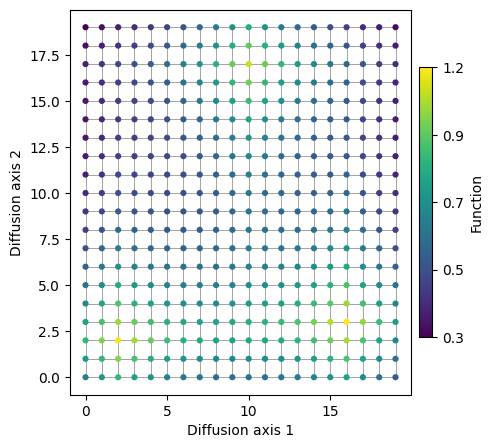

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plot.plot_visualization(axes, ndf, edges_df=edf,
                        nodes_size=20, edges_alpha=1)

This representation displays the structure and distribution of the phenotype of interest very clearly along the complete space. However, in more complicated spaces, such as sequence space, obtaining an intuitive low dimensional representation where we can see where these peaks are located and the relationships between them is not so straightforward. In the following section, we will explain how we can do it in this very simple example.

## Evolutionary model

We can define an evolutionary random walk on the graph representing a discrete space (e.g. sequence space). For convenience, we assume a Weak Mutation model of evolution, such that mutations are always fixed or lost before a new mutation arises. Lets start by assuming that mutation rates are uniform across all mutation types and compute the continuous time rate matrix $Q$, such that $Q_{ij}$ represents the rate at which a population at genotype $i$ evolves towards genotype $j$. This can be obtained by multiplying the assumed mutation rate of 1, by the fixation probability relative to a neutral substitution with scaled selection coefficient $S_{ij}$
the fixation probability relative to a neutral substitution.

$$
Q_{ij} =
\begin{cases}
    \frac{S_{ij}}{1 - e^{S_{ij}}} & \text{if i and j are neighbors}\\
    -\sum_{k \neq i} Q_{ik} & \text{if } i=j\\
    0 & \text{otherwise}
\end{cases}
$$

For simplicity, we also assume that $S_{ij}=c(f_j - f_i)$, in which case $c$ can be interpreted as $N_e s$ for a Wright-Fisher population. 

If we obtain the eigendecomposition of $\mathbf{Q}$

$$
\mathbf{Q} = \sum_k \lambda_k r_k l_k^T
$$

We can calculate the transition matrix after some time $t$

$$
P = e^{Qt} = \sum_k e^{\lambda_k t} r_k l_k^T
$$

We can now use this eigendecomposition to study how the probability of being at any possible state depends on a specific state $i$ after some time $t$ given by the vector $P_i$, where $l_0=\pi$ and $r_0=1$.

$$
P_i(t) = \sum_k e^{\lambda_k t} r_{k,i} l_k^T = e^{\lambda_1 t} r_{1,i} l_1^T + \sum_{k\geq2} e^{\lambda_k t} r_{k,i} l_k^T = \pi + \sum_{k\geq2} e^{\lambda_k t} r_{k,i} l_k^T
$$

The left eigenvectors $l_k$ form a basis for the probability distribution, with $l_1=\pi$. Thus, the probability of being at any genotype at time $t$ after being at genotype $i$ can be obtained as a linear combination of these basis vectors. The weights associated to each basis vector are given by $e^{\lambda_k t}r_{k,i}$. The first factor decays exponentially with time and the associacted eigenvalue $\lambda_k$ in a sequence independent manner, whereas $r_{k,i}$ controls how sequence $i$ influences the sequence probability distribution over time. As time increases, $P_i$ converges to $\pi$, becoming independent of sequence $i$. Therefore $r_{k,i}$ provides information about how sequence $i$ approaches the stationary distribution, such that sequences with similar values of $r_k$ will approach the stationary distribution in similar ways. 

We can calculate the projection coordinates $u_k$ normalizing the right eigenvectors by the square root of the decay rate $-\lambda_k$.

$$
u_k = \frac{r_k}{\sqrt{-\lambda_k}}\frac{1}{r_k^T D_\pi r_k}
$$

This way, the sum of square differences in the low dimensional representation approximates the commute times between every pair of states ($H_{ij} + H_{ji}$)

$$
H_{ij} + H_{ji} = \sum_{k\geq2} (u_{k,j} - u_{k,i})^2
$$

An important consequence is that we can such calculation without computing the dense distance matrix relating every pair of possible states to generate an embedding. This enables us to visualize spaces containing up to few million states for which a dense distance matrix can not even be stored in memory.  

## Intuitive understanding

In practice, as selection strength $s$ increases, paths that cross fitness valleys or containing deleterious mutations become less and less likely, increasing the time the random walk would take to evolve between different states of the discrete space. Thus, fitness peaks that are isolated from each other will be pushed appart, while states separated by many neutral paths will be pulled together in the low dimensional representation. 

Lets see how this happens in our 2D grid landscape

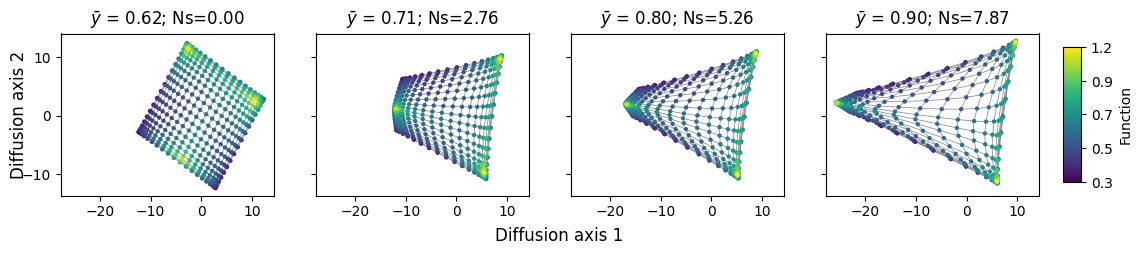

In [6]:
rw = WMWalk(space)
fig = plot.figure_Ns_grid(rw, nodes_size=10, edges_alpha=1,
                          ncol=4, nrow=1, pmin=0, pmax=0.5)

With very low selection strength, we can still appreciate the 2-dimensional grid quite accurately, given that distances in the new embedding remain very close to the original 2D representation the graph. However, as the selection strength increases, the 3 isolated peaks are pulled appart from each other. Interestingly, we can notice that there are 2 of the peaks that are slightly more accessible to each other, since they are separated along Diffusion axis 2, while the other peak at the opposite end of the grid is separated from them alon diffusion axis 1, showing that lower accessibility from the other two peaks.